In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import cv2

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = "C:\\Users\Administrator\\datasets\\"
input_directory = data_dir+'caltech-101'
images_directory = input_directory+'/'+'images'
gt_summary = input_directory+'/'+'gt_summary.csv'


df = pd.read_csv(gt_summary)

classes = ['airplanes', 'Faces', 'Motorbikes']
df = df[df['class'].isin(classes)].reset_index(drop=True)


df['imgpath'] = images_directory+'/'+df['filename']
imgpaths = np.array(df['imgpath'])


df['xmin'] = df['xmin']/df['width']
df['ymin'] = df['ymin']/df['height']
df['xmax'] = df['xmax']/df['width']
df['ymax'] = df['ymax']/df['height']
bboxes = np.array(df[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist(), dtype="float32")

labels = np.array(df['class'])
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

data = []
for imgpath in imgpaths:
    image = load_img(imgpath, target_size=(224, 224))
    image = img_to_array(image)
    data.append(image)
data = np.array(data, dtype="float32")/255.0

train_ratio = 0.75
val_ratio = 0.15
test_ratio = 0.10


(train_images, test_images, 
 train_labels, test_labels, 
 train_BBs, test_BBs, 
 train_paths, test_paths) = train_test_split(
    data, 
    labels, 
    bboxes, 
    imgpaths, 
    test_size=(1-train_ratio), random_state=42)

(val_images, test_images, 
 val_labels, test_labels, 
 val_BBs, test_BBs, 
 val_paths, test_paths) = train_test_split(
    test_images, 
    test_labels, 
    test_BBs, 
    test_paths, 
    test_size=test_ratio/(test_ratio + val_ratio), random_state=42)

print (train_images.shape, val_images.shape, test_images.shape)

(1524, 224, 224, 3) (305, 224, 224, 3) (204, 224, 224, 3)


In [3]:
backbone = applications.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))


for layer in backbone.layers:
    layer.trainable = False


x = layers.Flatten()(backbone.output)

cls = layers.Dense(512, activation='relu')(x)
cls = layers.Dropout(0.5)(cls)
cls = layers.Dense(512, activation='relu')(cls)
cls = layers.Dropout(0.5)(cls)
clshead = layers.Dense(3, activation='softmax', name="clshead")(cls)


reg = layers.Dense(128, activation='relu')(x)
reg = layers.Dense(64, activation='relu')(reg)
reg = layers.Dense(32, activation='relu')(reg)
reghead = layers.Dense(4, activation='sigmoid', name="reghead")(reg)


model = models.Model(inputs=backbone.input, outputs=[reghead, clshead])


opt = optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=opt,
    loss={"reghead": "mean_squared_error", "clshead": "categorical_crossentropy"},
    metrics={"reghead": "mse", "clshead": "accuracy"},
    loss_weights={"reghead": 1.0, "clshead": 1.0}
)
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                             

In [4]:
%%time
history = model.fit(
    train_images, {'clshead': train_labels, 'reghead': train_BBs},
    validation_data=(val_images, {'clshead': val_labels, 'reghead': val_BBs}),
    batch_size=32,
    epochs=15,
    verbose=1)

Epoch 1/15
48/48 [==============================] - 163s 3s/step - loss: 0.2138 - reghead_loss: 0.0148 - clshead_loss: 0.1990 - reghead_mse: 0.0148 - clshead_accuracy: 0.9252 - val_loss: 0.0033 - val_reghead_loss: 0.0018 - val_clshead_loss: 0.0014 - val_reghead_mse: 0.0018 - val_clshead_accuracy: 1.0000
Epoch 2/15
48/48 [==============================] - 159s 3s/step - loss: 0.0169 - reghead_loss: 0.0013 - clshead_loss: 0.0156 - reghead_mse: 0.0013 - clshead_accuracy: 0.9967 - val_loss: 0.0018 - val_reghead_loss: 0.0012 - val_clshead_loss: 5.7106e-04 - val_reghead_mse: 0.0012 - val_clshead_accuracy: 1.0000
Epoch 3/15
48/48 [==============================] - 159s 3s/step - loss: 0.0076 - reghead_loss: 8.5861e-04 - clshead_loss: 0.0067 - reghead_mse: 8.5861e-04 - clshead_accuracy: 0.9987 - val_loss: 0.0016 - val_reghead_loss: 0.0010 - val_clshead_loss: 5.8690e-04 - val_reghead_mse: 0.0010 - val_clshead_accuracy: 1.0000
Epoch 4/15
48/48 [==============================] - 159s 3s/step - lo

dict_keys(['loss', 'reghead_loss', 'clshead_loss', 'reghead_mse', 'clshead_accuracy', 'val_loss', 'val_reghead_loss', 'val_clshead_loss', 'val_reghead_mse', 'val_clshead_accuracy'])


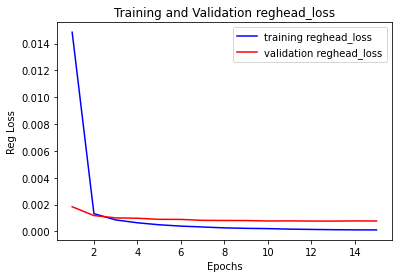

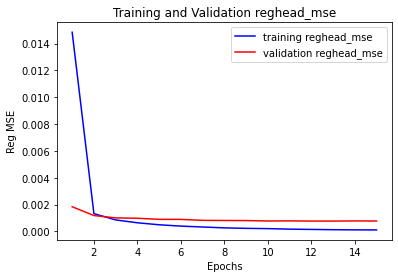

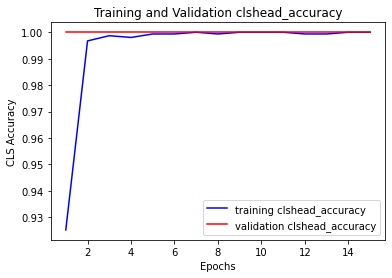

In [5]:
history_dict = history.history
print (history_dict.keys())


loss = history_dict['reghead_loss']
val_loss = history_dict['val_reghead_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='training reghead_loss')
plt.plot(epochs, val_loss, 'r', label='validation reghead_loss')
plt.title('Training and Validation reghead_loss')
plt.xlabel('Epochs')
plt.ylabel('Reg Loss')
plt.legend()
plt.show()


mse = history_dict['reghead_mse']
val_mse = history_dict['val_reghead_mse']
epochs = range(1, len(mse) + 1)
plt.plot(epochs, mse, 'b', label='training reghead_mse')
plt.plot(epochs, val_mse, 'r', label='validation reghead_mse')
plt.title('Training and Validation reghead_mse')
plt.xlabel('Epochs')
plt.ylabel('Reg MSE')
plt.legend()
plt.show()


acc = history_dict['clshead_accuracy']
val_acc = history_dict['val_clshead_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='training clshead_accuracy')
plt.plot(epochs, val_acc, 'r', label='validation clshead_accuracy')
plt.title('Training and Validation clshead_accuracy')
plt.xlabel('Epochs')
plt.ylabel('CLS Accuracy')
plt.legend()
plt.show()

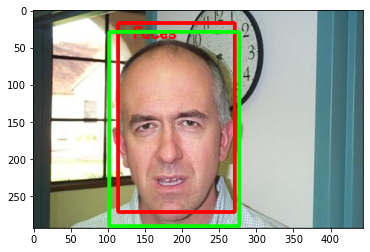

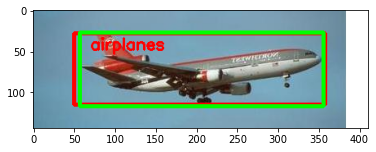

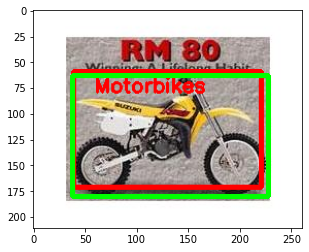

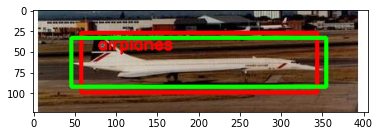

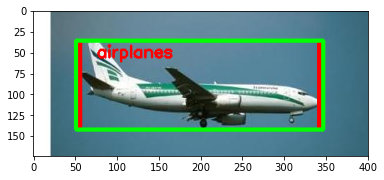

In [6]:
def predict_and_display(image_index=0):

    testimgpath = test_paths[image_index]
    img = cv2.imread(testimgpath)
    (height, width) = img.shape[:2]

    
    image = load_img(testimgpath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    
    gt_label = test_labels[image_index]

    # get gt BB
    (gtxmin, gtymin, gtxmax, gtymax) = test_BBs[image_index]

    
    gtxmin = int(gtxmin*width)
    gtymin = int(gtymin*height)
    gtxmax = int(gtxmax*width)
    gtymax = int(gtymax*height)

    
    (pred_BB, pred_label) = model.predict(image)

    
    pred_label = lb.classes_[np.argmax(pred_label, axis=1)][0]

    
    (pxmin, pymin, pxmax, pymax) = pred_BB[0]

    
    pxmin = int(pxmin*width)
    pymin = int(pymin*height)
    pxmax = int(pxmax*width)
    pymax = int(pymax*height)

    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.putText(img, pred_label, (pxmin+20, pymin+20), cv2.FONT_HERSHEY_SIMPLEX,0.65, (255, 0, 0), 2)
    cv2.rectangle(img, (pxmin, pymin), (pxmax, pymax), (255,0,0), 3)
    cv2.rectangle(img, (gtxmin, gtymin), (gtxmax, gtymax), (0,255,0), 3)
    plt.imshow(img)
    plt.show()


np.random.seed(42)
for idx in np.random.randint(0, test_images.shape[0], 5):
    predict_and_display(idx)